In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [2]:
def flipped_smooth_non_stationary_sine_with_trend(x, period_func, amplitude_func, trend_func):
    """
    Generate a smooth, non-stationary sine wave flipped over the horizontal axis with increasing period,
    smoothly varying amplitude, and a positive trend.

    Parameters:
    x (array-like): Input x values.
    period_func (function): Function defining the increasing period of the sine wave at each x.
    amplitude_func (function): Function defining the smoothly varying amplitude of the sine wave at each x.
    trend_func (function): Function defining the positive trend added to the sine wave.

    Returns:
    y (array-like): Non-stationary sine wave values that are always positive with a positive trend, flipped over the horizontal axis.
    """
    periods = period_func(x)
    amplitudes = amplitude_func(x)
    trend = trend_func(x)
    y = amplitudes - amplitudes * np.sin(2 * np.pi * x / periods) + trend
    return y

In [3]:
def upper_confidence_bound(mean, std, kappa):
    """
    Compute the Upper Confidence Bound (UCB) acquisition function.

    Parameters:
    mean (array-like): Predicted mean of the surrogate model at the given points.
    std (array-like): Predicted standard deviation (uncertainty) of the surrogate model at the given points.
    kappa (float): Exploration-exploitation trade-off parameter.

    Returns:
    ucb (array-like): UCB values at the given points.
    """
    ucb = mean - kappa * std
    return ucb

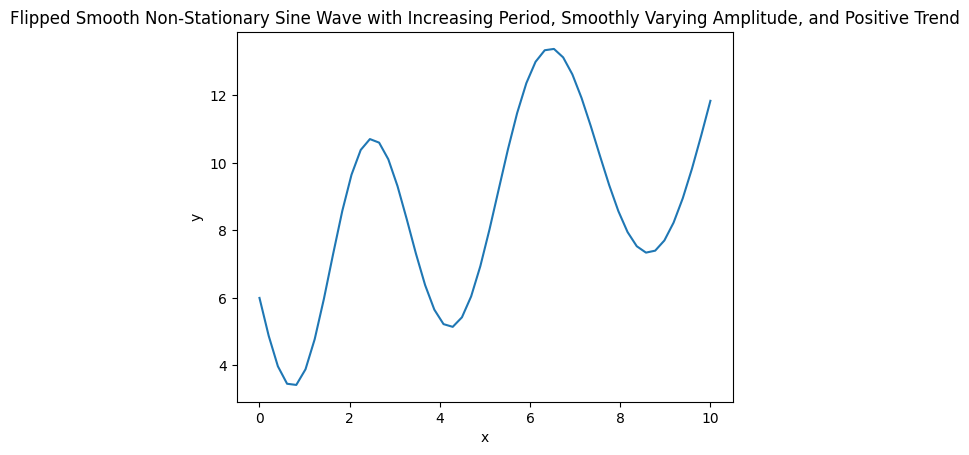

In [4]:
# Example usage
x = np.linspace(0, 10, 50)

# Define a smoothly increasing period function
period_func = lambda x: 3 + 0.1 * x  # Period increases smoothly with x

# Define a smoothly varying amplitude function
amplitude_func = lambda x: 3 + np.sin(0.1 * x)  # Smoothly varying amplitude

# Define a positive trend function
trend_func = lambda x: 0.5 * x + 3  # Positive linear trend

# Generate the flipped non-stationary sine wave with a positive trend
y = flipped_smooth_non_stationary_sine_with_trend(x, period_func, amplitude_func, trend_func)

# Plot the result
plt.plot(x, y)
plt.title("Flipped Smooth Non-Stationary Sine Wave with Increasing Period, Smoothly Varying Amplitude, and Positive Trend")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [5]:
kappa = 0.05 # 5 # 0.05 # 5
sampled_idx = []
np.random.seed(3)

for i in range(20):
    # kernel = 1 * RBF(length_scale=1e-2, length_scale_bounds=(1e-4, 1))
    kernel = 1 * RBF(length_scale=10, length_scale_bounds=(1e-4, 10))
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
    
    if i == 0:
        rng = np.random.RandomState(1)
        training_indices = rng.choice(np.arange(y.size), size=1, replace=False)
        x_train, y_train = x[training_indices].reshape(-1, 1), y[training_indices]
    else:
        x_train, y_train = x[sampled_idx].reshape(-1, 1), y[sampled_idx]
        
    gaussian_process.fit(x_train, y_train)
    mean, std = gaussian_process.predict(x.reshape(-1, 1), return_std=True)
    # Compute the UCB acquisition values
    ucb_values = upper_confidence_bound(mean, std, kappa)
    # max_ucb = np.argmin(ucb_values)
    min_ucb = np.argmin(ucb_values)
    sampled_idx.append(min_ucb)
    sampled_ucb = ucb_values[sampled_idx]

/Users/timurbikmuhametov/miniconda3/envs/ml_blog/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/timurbikmuhametov/miniconda3/envs/ml_blog/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/timurbikmuhametov/miniconda3/envs/ml_blog/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/module

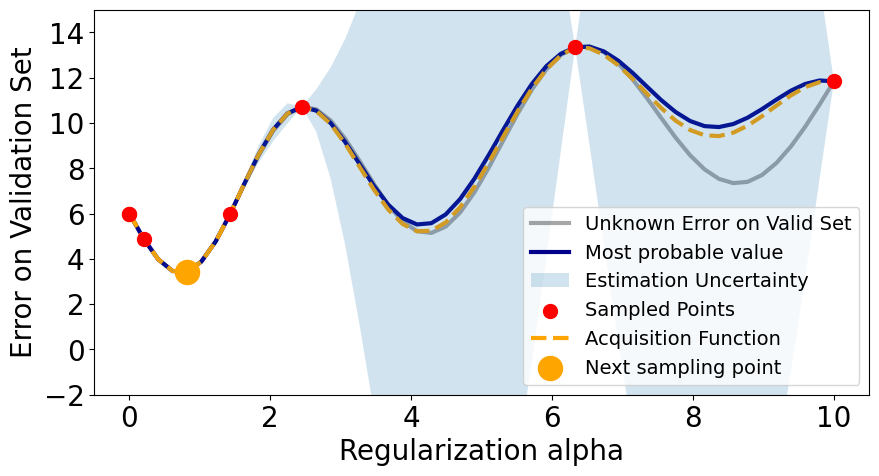

In [6]:
# Plot the result
plt.figure(figsize=(10, 5))
plt.plot(x, y, color='black', lw=3, zorder=-1, label='Unknown Error on Valid Set', alpha=0.35)
plt.plot(x, mean, label='Most probable value', color='darkblue', lw=3, zorder=-1)
plt.fill_between(x.ravel(), mean - 3*std, mean + 3*std, alpha=0.2, label='Estimation Uncertainty')
plt.scatter(x_train, y_train, c='red', label='Sampled Points', s=100)

plt.plot(x, ucb_values, label='Acquisition Function', linestyle='--', color='orange', lw=3, zorder=-1)
plt.scatter(x[np.argmin(ucb_values)], np.min(ucb_values), color='orange', s=300, label='Next sampling point')

# plt.scatter(x_train[np.argmin(y_train)], y_train[np.argmin(y_train)], color='lightgreen', s=100, 
#            label='Current best alpha')

# plt.scatter(x[np.argmin(y)], y[np.argmin(y)], color='green', s=200, label='Error minimum')
# plt.plot([x[np.argmin(y)], x[np.argmin(y)]], [0, y[np.argmin(y)]], color='green', ls='--', lw=2)

plt.xlabel("Regularization alpha", fontdict={'size': 20})
plt.ylabel("Error on Validation Set", fontdict={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(-2, 15)
plt.legend(prop={'size': 14})
plt.show()

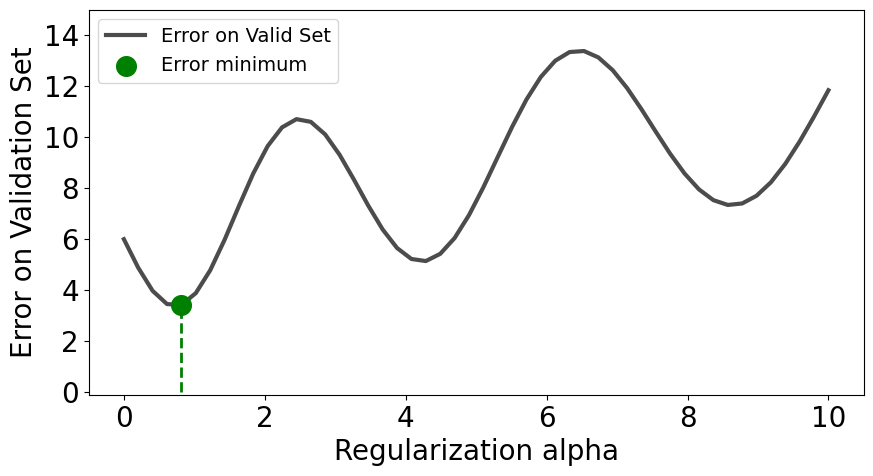

In [7]:
# Plot the result
plt.figure(figsize=(10, 5))
plt.plot(x, y, color='black', lw=3, zorder=-1, label='Error on Valid Set', alpha=0.7)
# # plt.plot(x, mean, label='Gaussian Process Mean', color='darkblue', lw=3, zorder=-1)
# plt.plot(x, mean, label='Most probable value', color='darkblue', lw=3, zorder=-1)
# plt.fill_between(x.ravel(), mean - 5*std, mean + 5*std, alpha=0.2, label='Estimation Uncertainty')
# # plt.plot(x, ucb_values, label='UCB Acquisition Function', linestyle='--', color='orange', lw=3, zorder=-1)

# plt.scatter(x_train, y_train, c='red', label='Sampled Points', s=100)
# # plt.scatter(x[np.argmin(ucb_values)], np.min(ucb_values), color='orange', s=100, label='Next sampling point')

# # plt.scatter(x_train[np.argmin(y_train)], y_train[np.argmin(y_train)], color='lightgreen', s=100, 
# #            label='Current best alpha')
plt.scatter(x[np.argmin(y)], y[np.argmin(y)], color='green', s=200, label='Error minimum')

plt.plot([x[np.argmin(y)], x[np.argmin(y)]], [0, y[np.argmin(y)]], color='green', ls='--', lw=2)

plt.xlabel("Regularization alpha", fontdict={'size': 20})
plt.ylabel("Error on Validation Set", fontdict={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(-0.1, 15)
plt.legend(prop={'size': 14})
plt.show()

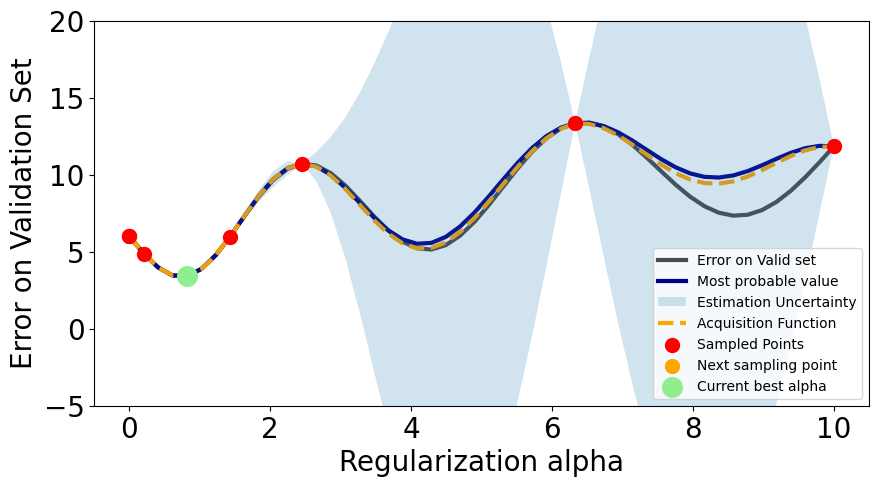

In [8]:
# Plot the result
plt.figure(figsize=(10, 5))
plt.plot(x, y, color='black', lw=3, zorder=-1, label='Error on Valid set', alpha=0.7)
plt.plot(x, mean, label='Most probable value', color='darkblue', lw=3, zorder=-1)
plt.fill_between(x.ravel(), mean - 3*std, mean + 3*std, alpha=0.2, label='Estimation Uncertainty')
plt.plot(x, ucb_values, label='Acquisition Function', linestyle='--', color='orange', lw=3, zorder=-1)

plt.scatter(x_train, y_train, c='red', label='Sampled Points', s=100)
plt.scatter(x[np.argmin(ucb_values)], np.min(ucb_values), color='orange', s=100, label='Next sampling point')

plt.scatter(x_train[np.argmin(y_train)], y_train[np.argmin(y_train)], color='lightgreen', s=200, 
           label='Current best alpha')
# plt.scatter(x[np.argmin(y)], y[np.argmin(y)], color='green', s=200, label='Error minimum')

# plt.plot([x[np.argmin(y)], x[np.argmin(y)]], [0, y[np.argmin(y)]], color='green', ls='--', lw=2)

plt.xlabel("Regularization alpha", fontdict={'size': 20})
plt.ylabel("Error on Validation Set", fontdict={'size': 20})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(-5, 20)
plt.legend(prop={'size': 10})
plt.show()